In [ ]:
### This code contains milopy analysis on entire dataset shown in Figure 1

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb
import ma_codes as codes
from ma_codes import mysize, gray_red, mymap
import pertpy as pt
import seaborn as sns
%matplotlib inline
sc.settings.verbosity = 3               # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_version_and_date()

Running Scanpy 1.10.2, on 2025-05-06 16:35.


In [2]:
plot_folder = "/home/gotej/Projects/Aging_BleoModel/Plots/"
plt.rcParams['pdf.fonttype'] = 42

### Load data objects

In [3]:
object_folder = "/media/HDD_1/Janine/Aging_SingleCell/data_objects/"
adata = sc.read(object_folder + "230111_Bleo_Ageing_annotated_final.h5ad")

sc.set_figure_params(adata, vector_friendly=True, format='pdf', dpi_save=300, facecolor=None, transparent=False, ipython_format='png2x')
plt.rcParams['pdf.fonttype'] = 42

In [4]:
adata

AnnData object with n_obs × n_vars = 160477 × 29814
    obs: 'age', 'barcode', 'batch', 'day', 'name', 'sex', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'doublet_scores', 'size_factors', 'S_score', 'G2M_score', 'phase', 'time_point', 'leiden_1', 'leiden_2', 'domain', 'cell_type', 'ct_level2', 'compartment_label', 'meta_label', 'age_treatment', 'age_day'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'age_colors', 'age_day_colors', 'age_treatment_colors', 'batch_colors', 'cell_type_colors', 'compartment_label_colors', 'ct_level2_colors', 'day_colors', 'dendrogram_cell_type', 'domain_colors', 'hvg', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'meta_label_colors', 'name_colors', 'neighbors', 'pca', 'sex_colors', 'time_point_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connect

### MiloPy - Old Bleo vs Old Control

In [19]:
milo = pt.tl.Milo()
mdata = milo.load(adata)

In [20]:
mdata

MuData object with n_obs × n_vars = 160477 × 29814
  2 modalities
    rna:	160477 x 29814
      obs:	'age', 'barcode', 'batch', 'day', 'name', 'sex', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'doublet_scores', 'size_factors', 'S_score', 'G2M_score', 'phase', 'time_point', 'leiden_1', 'leiden_2', 'domain', 'cell_type', 'ct_level2', 'compartment_label', 'meta_label', 'age_treatment', 'age_day'
      var:	'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'age_colors', 'age_day_colors', 'age_treatment_colors', 'batch_colors', 'cell_type_colors', 'compartment_label_colors', 'ct_level2_colors', 'day_colors', 'dendrogram_cell_type', 'domain_colors', 'hvg', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'meta_label_colors', 'name_colors', 'neighbors', 'pca', 'sex_colors', 'time_point_colors', 'treatment_colors', 'umap', 'dendrogram_meta_label', 'rank_genes_groups'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'unsouped_counts'
      obsp:	'connectivities', 'distances'
    milo:	0 x 0

In [21]:
sc.pp.neighbors(mdata["rna"], use_rep="X_umap", n_neighbors=50)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:02)


In [22]:
milo.make_nhoods(mdata["rna"], prop=0.1)

In [23]:
mdata["rna"].obsm["nhoods"]

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 830044 stored elements and shape (160477, 15178)>

In [24]:
mdata["rna"][mdata["rna"].obs["nhood_ixs_refined"] != 0].obs[["nhood_ixs_refined", "nhood_kth_distance"]]

,nhood_ixs_refined,nhood_kth_distance
muc26493_TCCATCGAACCA,1,0.099137
muc26493_TAGTGCCGCCTT,1,0.127406
muc26493_CACCCGCGACTG,1,0.129680
muc26493_TTGAGCCCACCC,1,0.147060
muc26493_GTCAGACAACAC,1,0.148219
...,...,...
muc26548_TCACAAAGTCTG,1,0.130162
muc26548_AAAGTCCTCCCT,1,0.142884
muc26548_CAATTACCTCGG,1,0.088518
muc26548_AGCGATCACTTG,1,0.104940


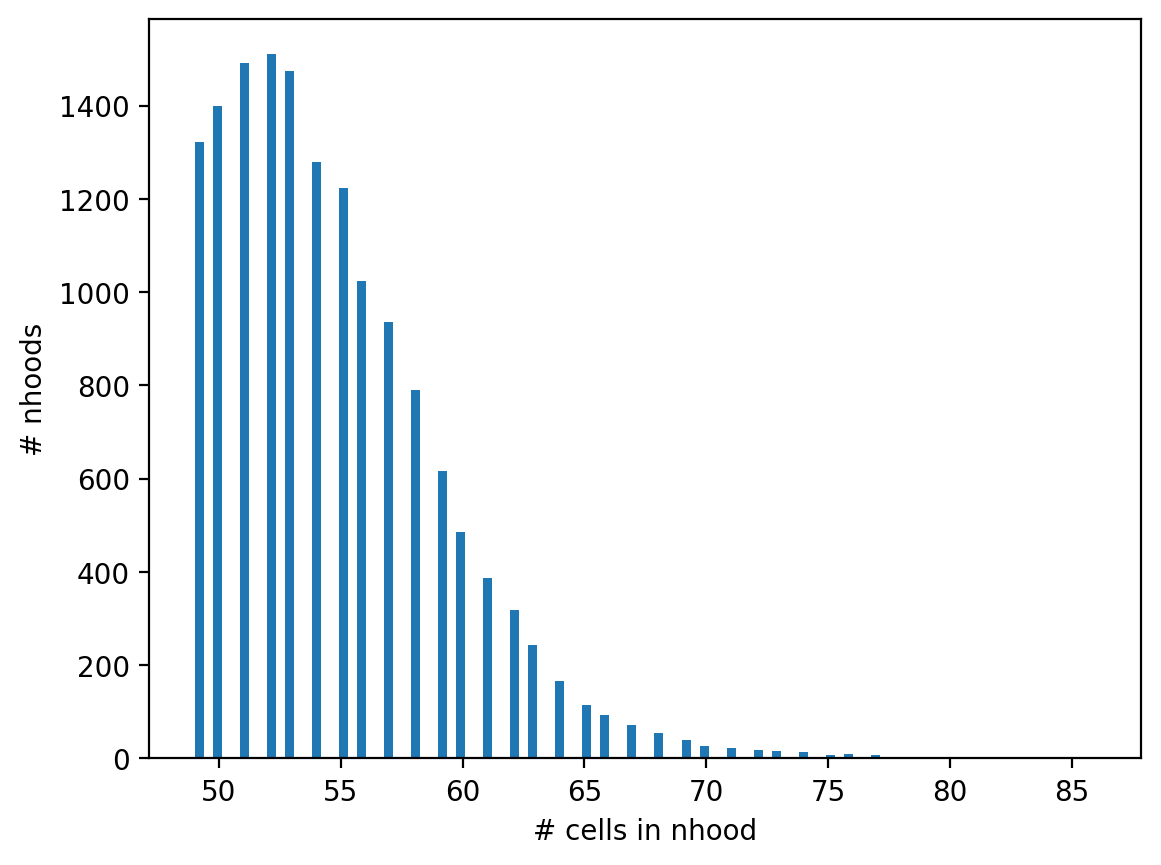

In [25]:
nhood_size = np.array(mdata["rna"].obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100)
plt.xlabel("# cells in nhood")
plt.ylabel("# nhoods");

In [26]:
mdata = milo.count_nhoods(mdata, sample_col="name")

In [27]:
mdata["milo"]

AnnData object with n_obs × n_vars = 55 × 15178
    var: 'index_cell', 'kth_distance'
    uns: 'sample_col'

In [28]:
mdata["rna"].obs["age_treatment"] = mdata["rna"].obs["age_treatment"].cat.reorder_categories(["young_control", "old_control", "young_bleo", "old_bleo"])
milo.da_nhoods(mdata, design="~age_treatment", model_contrasts="age_treatmentold_bleo-age_treatmentold_control")

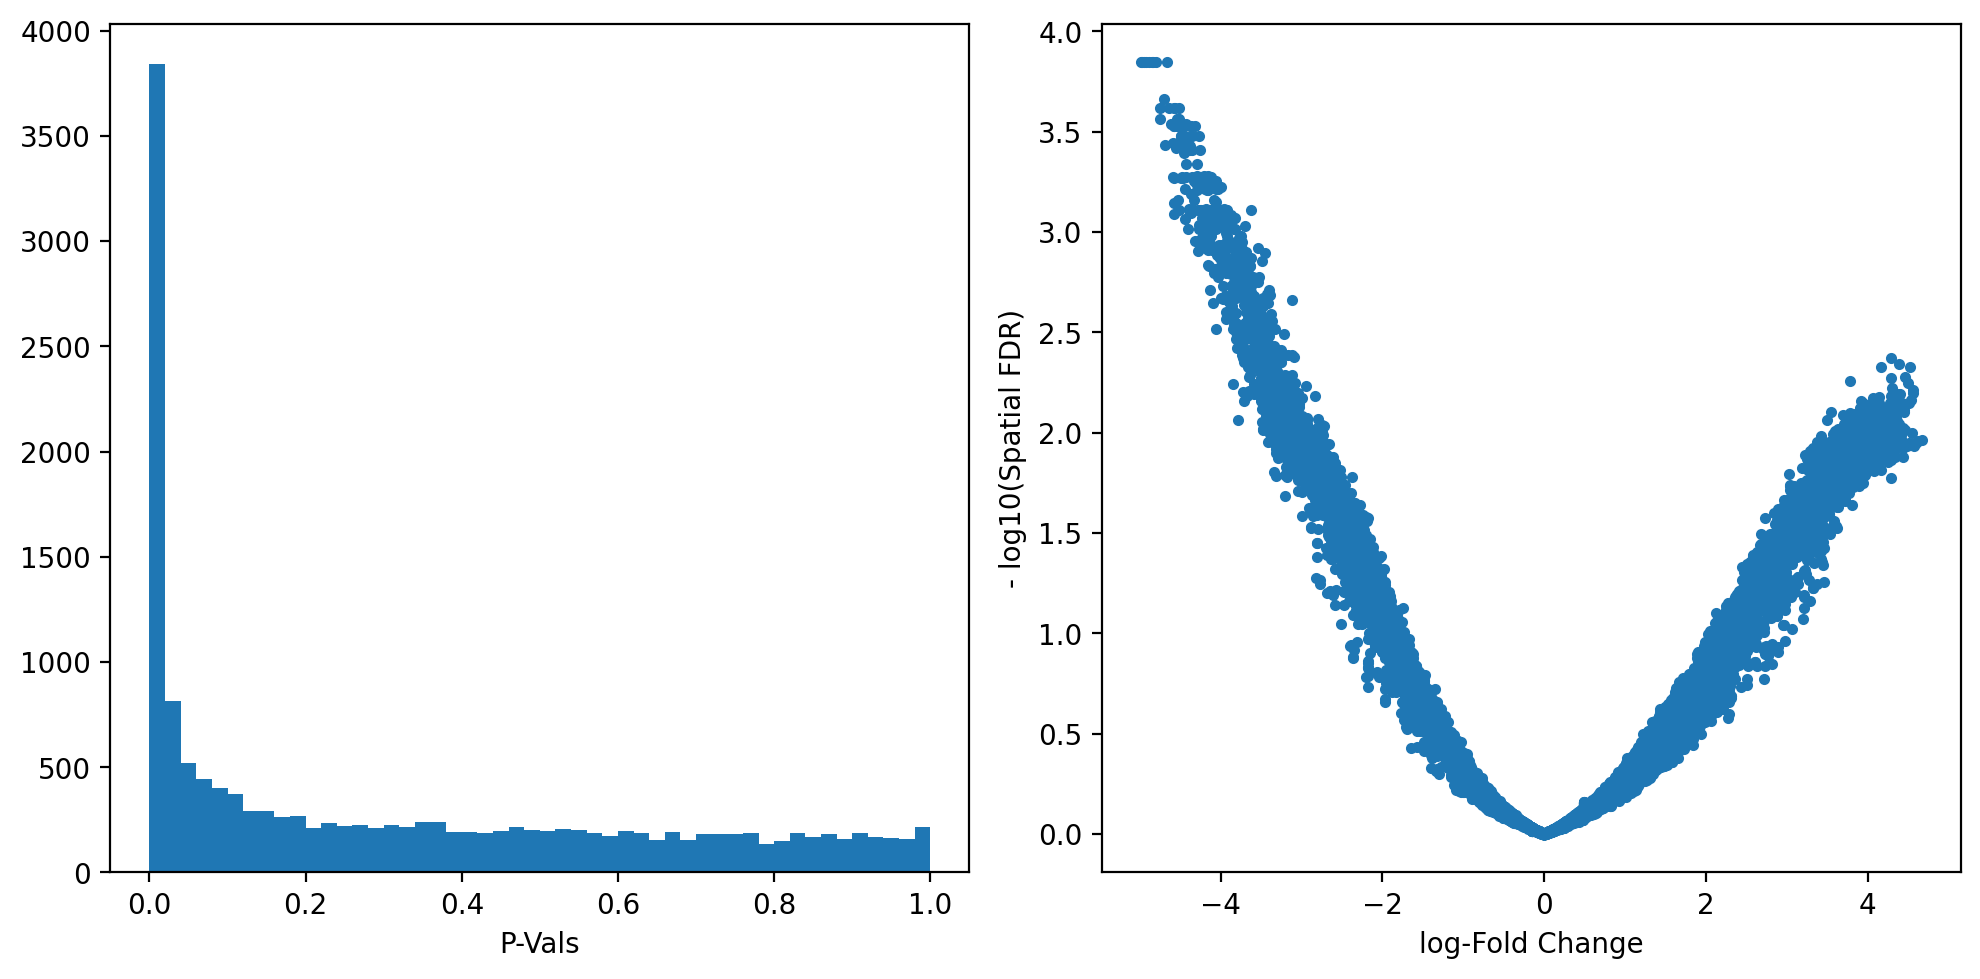

In [29]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10, 5]
plt.subplot(1, 2, 1)
plt.hist(mdata["milo"].var.PValue, bins=50)
plt.xlabel("P-Vals")
plt.subplot(1, 2, 2)
plt.plot(mdata["milo"].var.logFC, -np.log10(mdata["milo"].var.SpatialFDR), ".")
plt.xlabel("log-Fold Change")
plt.ylabel("- log10(Spatial FDR)")
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

In [30]:
milo.build_nhood_graph(mdata)

In [31]:
def patched_plot_nhood_graph(
    self,
    mdata,
    alpha=0.1,
    min_logFC=0,
    min_size=10,
    plot_edges=False,
    title="DA log-Fold Change",
    color_map=None,
    palette=None,
    ax=None,
    show=None,
    save=None,
    **kwargs,
):
    nhood_adata = mdata["milo"].T.copy()

    if "Nhood_size" not in nhood_adata.obs.columns:
        raise KeyError(
            'Cannot find "Nhood_size" column in adata.uns["nhood_adata"].obs -- '
            'please run milopy.utils.build_nhood_graph(adata)'
        )

    nhood_adata.obs["graph_color"] = nhood_adata.obs["logFC"]
    nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] > alpha, "graph_color"] = np.nan
    nhood_adata.obs["abs_logFC"] = abs(nhood_adata.obs["logFC"])
    nhood_adata.obs.loc[nhood_adata.obs["abs_logFC"] < min_logFC, "graph_color"] = np.nan

    # Plotting order - extreme logFC on top
    nhood_adata.obs.loc[nhood_adata.obs["graph_color"].isna(), "abs_logFC"] = np.nan
    ordered = nhood_adata.obs.sort_values("abs_logFC", na_position="first").index
    nhood_adata = nhood_adata[ordered]

    # Here we adjust to enable a fixed vmax and vmin to achieve comparabliity
    vmax = kwargs.pop("vmax", np.max([nhood_adata.obs["graph_color"].max(), abs(nhood_adata.obs["graph_color"].min())]))
    vmin = kwargs.pop("vmin", -vmax)

    sc.pl.embedding(
        nhood_adata,
        "X_milo_graph",
        color="graph_color",
        cmap="RdBu_r",
        size=nhood_adata.obs["Nhood_size"] * min_size,
        edges=plot_edges,
        neighbors_key="nhood",
        sort_order=False,
        frameon=False,
        vmax=vmax,
        vmin=vmin,
        title=title,
        color_map=color_map,
        palette=palette,
        ax=ax,
        show=show,
        save=save,
        **kwargs,
    )


In [32]:
import types
milo.plot_nhood_graph = types.MethodType(patched_plot_nhood_graph, milo)

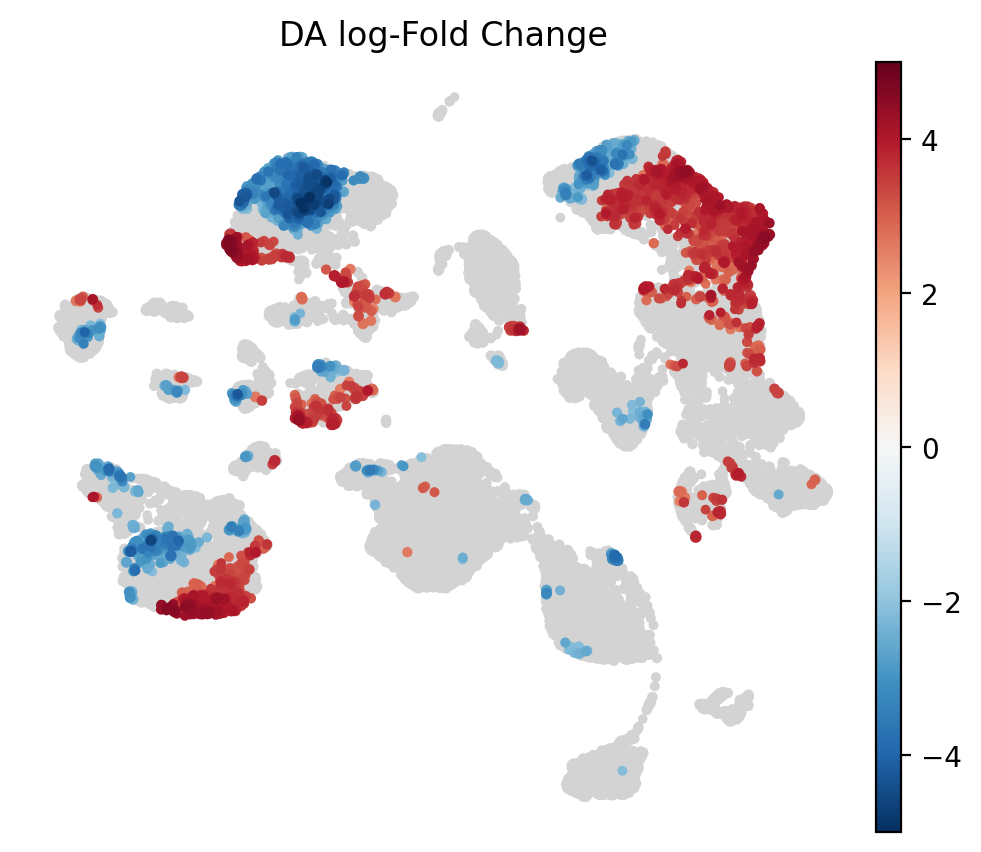

In [33]:
plt.rcParams["figure.figsize"] = [6, 5]
milo.plot_nhood_graph(
    mdata,
    alpha=0.05,
    min_size=1,
    vmax= 5,
    vmin=-5,
    save="_whole_old_bleo_vs_old_control.pdf")

In [34]:
milo.annotate_nhoods(mdata, anno_col="cell_type")

Text(0.5, 0, 'celltype fraction')

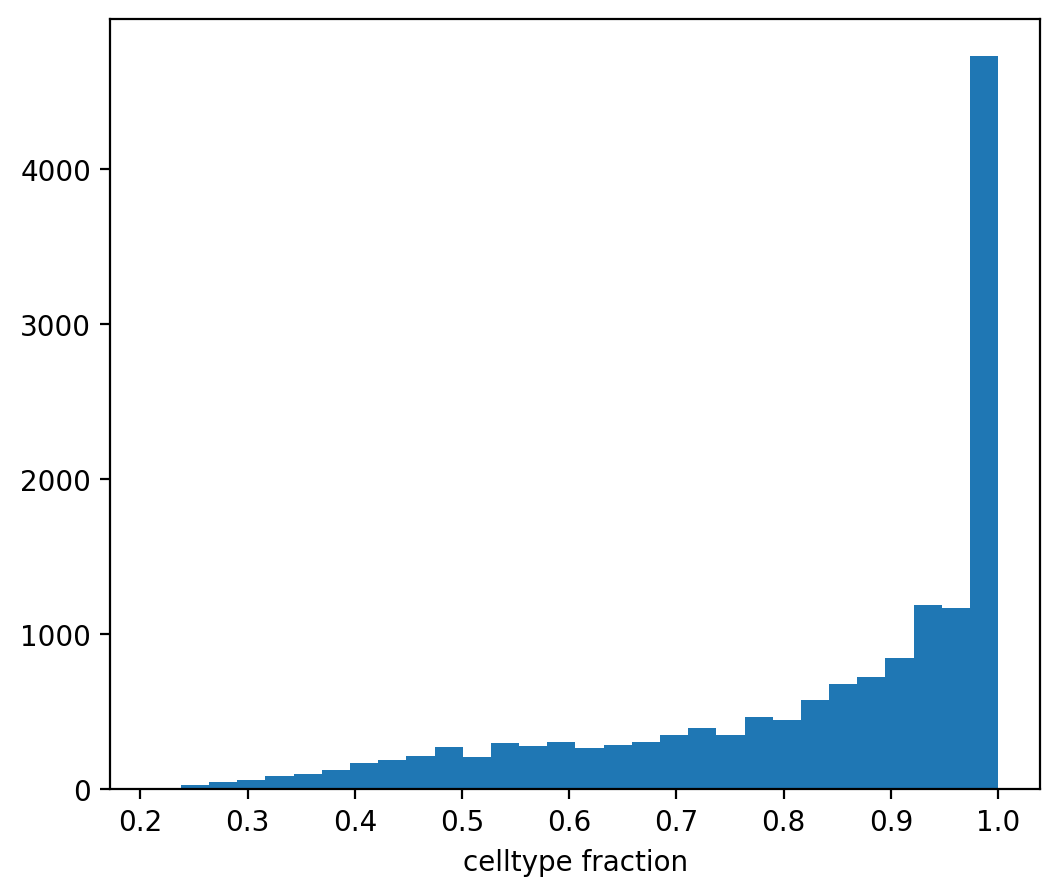

In [35]:
plt.hist(mdata["milo"].var["nhood_annotation_frac"], bins=30)
plt.xlabel("celltype fraction")

In [36]:
mdata["milo"].var.nhood_annotation = mdata["milo"].var.nhood_annotation.cat.add_categories('Mixed')

In [37]:
#mdata["milo"].var.nhood_annotation.cat.add_categories('Mixed')

In [38]:
mdata["milo"].var.loc[mdata["milo"].var["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

In [39]:
mdata["milo"]

AnnData object with n_obs × n_vars = 55 × 15178
    obs: 'age_treatment', 'name'
    var: 'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'SpatialFDR', 'Nhood_size', 'nhood_annotation', 'nhood_annotation_frac'
    uns: 'sample_col', 'nhood', 'annotation_labels', 'annotation_obs'
    varm: 'X_milo_graph', 'frac_annotation'
    varp: 'nhood_connectivities'

In [40]:
new_cols= {
### Epithelium ###
    'AT2' :'#2A3F87', #'#08519c',
    'AT2 activated' : '#78C5EC',  #'#9ecae1',
    'Krt8-ADI' : '#EDA554', #'#fd8d3c',
    'AT1' : '#D76346', #'#ffeda0',
    'Basal': '#fed9a6', 
    'Ciliated': '#004529',
    'Club' : '#59933B',
    'Club/Ciliated' :'#ccebc5', #'#f46d43',
    'Goblet' : '#a6d96a',
    'PNEC' : '#ffffbf',
    
### MNP ###
    'AΜΦ' : '#bfd3e6',
    'Spp1+ AΜΦ' :'#88419d',
    'Spp1+ Trem2+ ΜΦ' : '#810f7c',
    'MHCII+ Cx3cr1+ ΜΦ' : '#F7A489',
    'MHCII+ S100a6+ ΜΦ' : '#fee0d2',
    'Cd163+ Lyve1+ ΜΦ': '#fdbb84',
    'Prg4+ ΜΦ':'#fc8d59',
    'Resolution ΜΦ': '#4d004b' ,
    'MHCII+ Mono' : '#d9d9d9',
    'Arg1+ Mono' : '#d4b9da',
    'classical Mono': '#000000',
    'non-classical Mono': '#969696',
    'Proliferating ΜΦ': '#bcbddc',
    'Proliferating cDC1' : '#ef3b2c',
    'cDC1': '#b30000',
    'Proliferating cDC2': '#cc4c02',
    'cDC2': '#ef6548',
    'pDC' : '#DD260E',
    'Migratory DC': '#67000d',
    
### Lymphocytes ###
    'Mature B': '#80cdc1',
    'Memory B': '#01665e',
    'Age-associated B': '#c7eae5',
    'GC-like B': '#AC8956',
    'Proliferating B': '#CDB27E',
    'IgA plasma' : '#C0A095',
    'IgM plasma': '#86564B',
    'IgG plasma': '#f6e8c3',
    'Naive T': '#4eb3d3',
    'Memory T':'#B8D5E0',
    'Gzmk+ T': '#e31a1c',
    'Cytotoxic T': '#ec7014' ,
    'Treg': '#fec44f',
    'Th2': '#fee391',
    'Th17': '#fe9929',
    'T_stress': '#fee8c8',
    'NK' :'#993404',
    'Proliferating T' :'#fdbb84' ,
    'Megakarocytes': '#E65DC8',
    
### Granulocytes ###
     'Neutrophils' :'red',
     'Eosinophils' :'#FCE056',
     'Basophils/Mast cells': '#5e4fa2',
        
### Mesenchyme ###
    'Adventitial fibroblasts' : '#AE818F',
    'Lipofibroblasts'  : '#824253',
    'Transition'  : '#D05E81',
    'Spp1+ myofibroblasts' : '#CF645D',
    'Cthrc1+ myofibroblasts' : '#C43A35',
    'Adh7+ fibroblasts' : '#ECBFCD',
    'Lgr5+ Lgr6+ fibroblasts' : '#BBBECE',
    'Lgr5- Lgr6+ fibroblasts' : '#2B2E42',
    'Pericytes': '#667FC7',
    'SMC' :'#77A2C0',
    'Mesothel' :'#81888E',
    
### Endothelium ###
   'aCap' :'#fde0ef', 
   'gCap' :'#c51b7d',
   'activated gCap': '#7a0177',
   'arterial EC' :'#7fbc41',
   'venous EC' :'#e6f5d0',
   'LEC' :'green',
   'Proliferating EC' : '#bebada',

   "Mixed": "white"}

In [41]:
order = ['AT2', 'AT2 activated','Krt8-ADI','AT1','Basal','Ciliated','Club','Club/Ciliated','Goblet','PNEC', 'AΜΦ',
         'Spp1+ AΜΦ','Spp1+ Trem2+ ΜΦ','MHCII+ Cx3cr1+ ΜΦ','MHCII+ S100a6+ ΜΦ','Cd163+ Lyve1+ ΜΦ','Prg4+ ΜΦ',
         'Resolution ΜΦ','MHCII+ Mono','Arg1+ Mono','classical Mono','non-classical Mono',
         'Proliferating ΜΦ','Proliferating cDC1','cDC1','Proliferating cDC2','cDC2','pDC',
         'Migratory DC','Mature B','Memory B','Age-associated B','GC-like B','Proliferating B','IgA plasma',
         'IgM plasma','IgG plasma','Naive T','Memory T','Gzmk+ T','Cytotoxic T','Treg','Th2','Th17',
         'T_stress','NK','Proliferating T','Megakarocytes','Neutrophils','Eosinophils','Basophils/Mast cells',
         'Adventitial fibroblasts','Lipofibroblasts','Transition','Spp1+ myofibroblasts',
         'Cthrc1+ myofibroblasts','Adh7+ fibroblasts','Lgr5+ Lgr6+ fibroblasts','Lgr5- Lgr6+ fibroblasts',
         'Pericytes','SMC','Mesothel','aCap', 'gCap','activated gCap','arterial EC',
         'venous EC','LEC','Proliferating EC', 'Mixed']

In [42]:
mdata["milo"].var.nhood_annotation = mdata["milo"].var.nhood_annotation.cat.reorder_categories(order)

In [43]:
nhood_adata = mdata["milo"].T.copy()
anno_col = "nhood_annotation"
alpha = 0.05

anno_df = nhood_adata.obs[[anno_col, "logFC", "SpatialFDR"]].copy()
anno_df["is_signif"] = anno_df["SpatialFDR"] < alpha
anno_df = anno_df[anno_df[anno_col] != "nan"]

In [44]:
nhood_adata = mdata["milo"].T.copy()
anno_col = "nhood_annotation"
alpha = 0.05
old_df = nhood_adata.obs[[anno_col, "logFC", "SpatialFDR"]].copy()
old_df["is_signif"] = anno_df["SpatialFDR"] < alpha
old_df = anno_df[anno_df[anno_col] != "nan"]
old_df["age"] = "old"

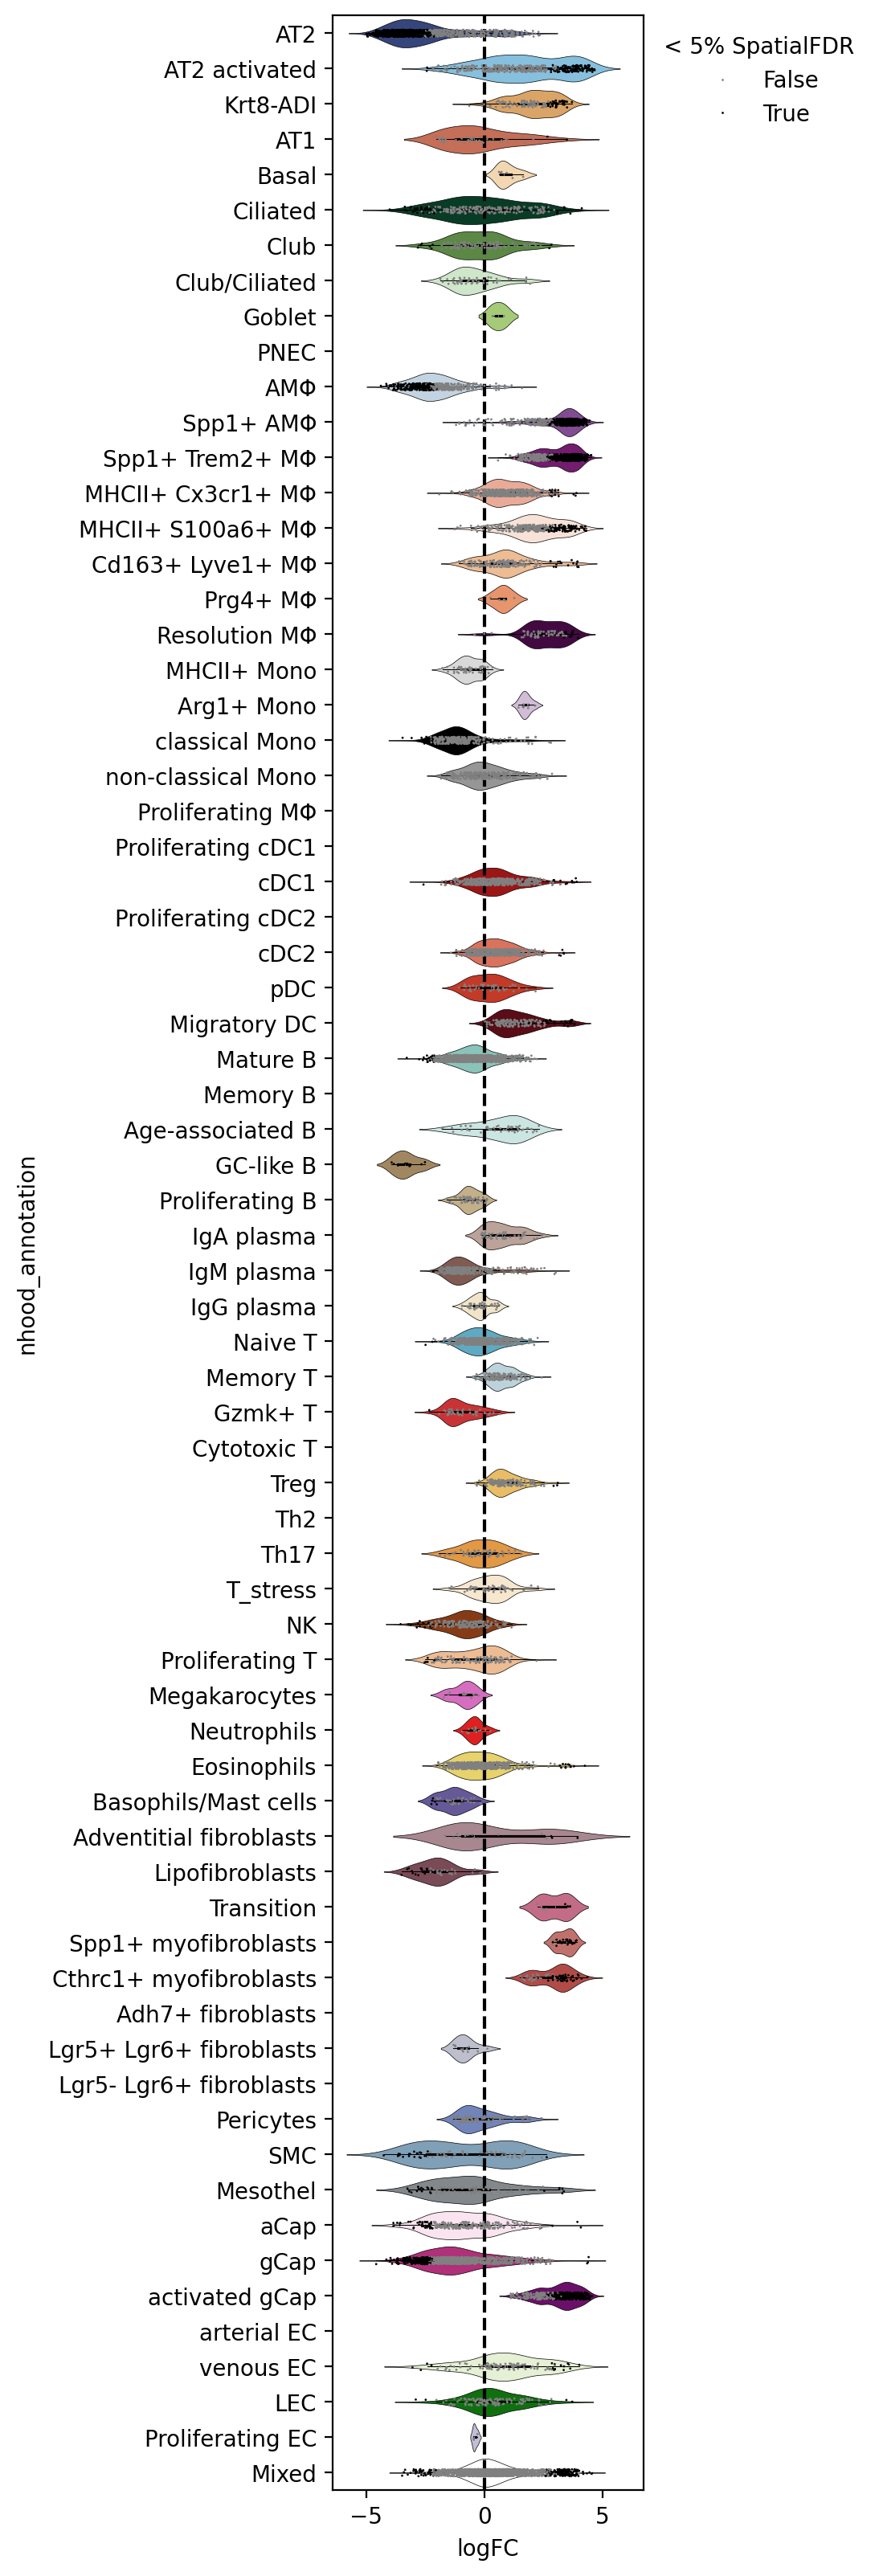

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(2.5,20)
sns.violinplot(data=anno_df, y=anno_col, x="logFC", order=order, orient="h", palette=new_cols, linewidth=0.25,
               scale="width", edgecolor="black")
sns.stripplot(data=anno_df, y=anno_col, x="logFC", order=order, size=1, hue="is_signif", palette=["grey", "black"], orient="h", alpha=1)
plt.legend(loc="upper left", title=f"< {int(alpha * 100)}% SpatialFDR", bbox_to_anchor=(1, 1), frameon=False)
plt.axvline(x=0, ymin=0, ymax=1, color="black", linestyle="--")
#plt.tight_layout()
plt.savefig("/home/gotej/Projects/Aging_BleoModel/Paper_figures/figures/" + "_Milo_bs_unsorted__old_bleo_vs_old_control.pdf" )

### MiloPy -  Bleo vs Control (Young/Old Combined)

In [46]:
mdata["rna"].obs["treatment"] = mdata["rna"].obs["treatment"].cat.reorder_categories(["control", "bleo"])
milo.da_nhoods(mdata, design="~treatment")

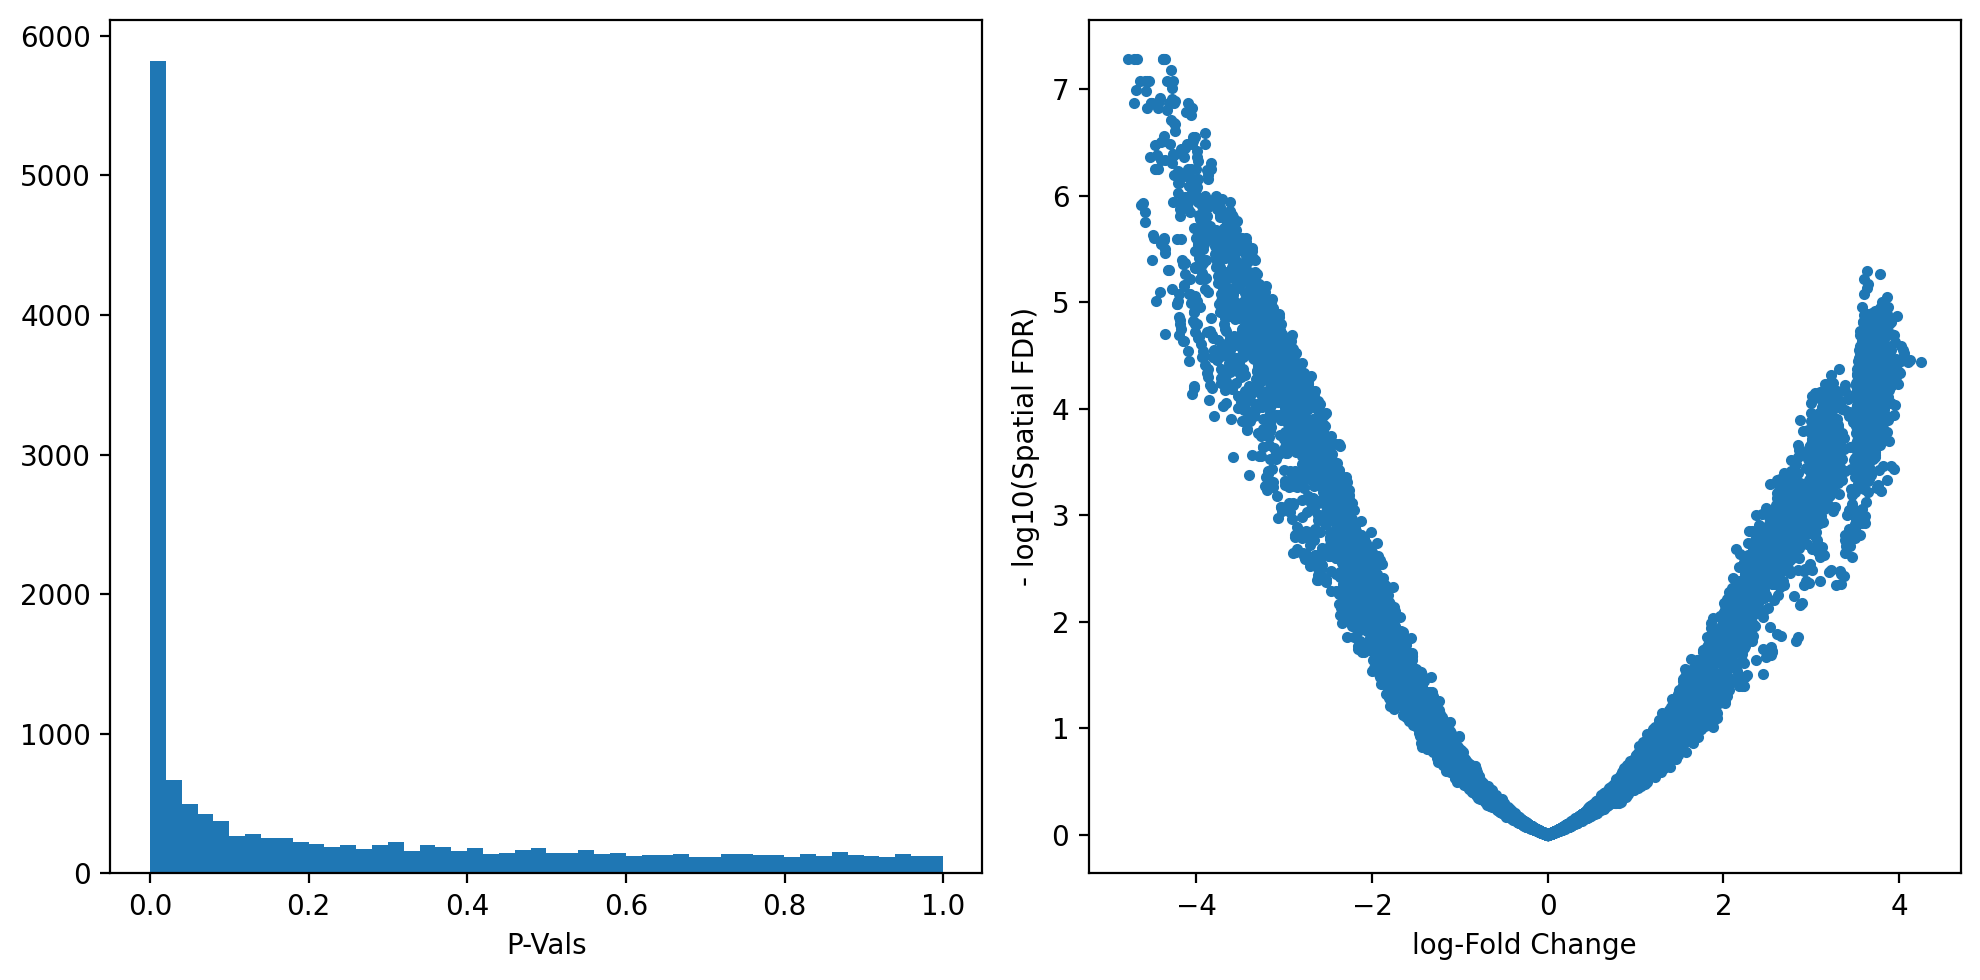

In [47]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10, 5]
plt.subplot(1, 2, 1)
plt.hist(mdata["milo"].var.PValue, bins=50)
plt.xlabel("P-Vals")
plt.subplot(1, 2, 2)
plt.plot(mdata["milo"].var.logFC, -np.log10(mdata["milo"].var.SpatialFDR), ".")
plt.xlabel("log-Fold Change")
plt.ylabel("- log10(Spatial FDR)")
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

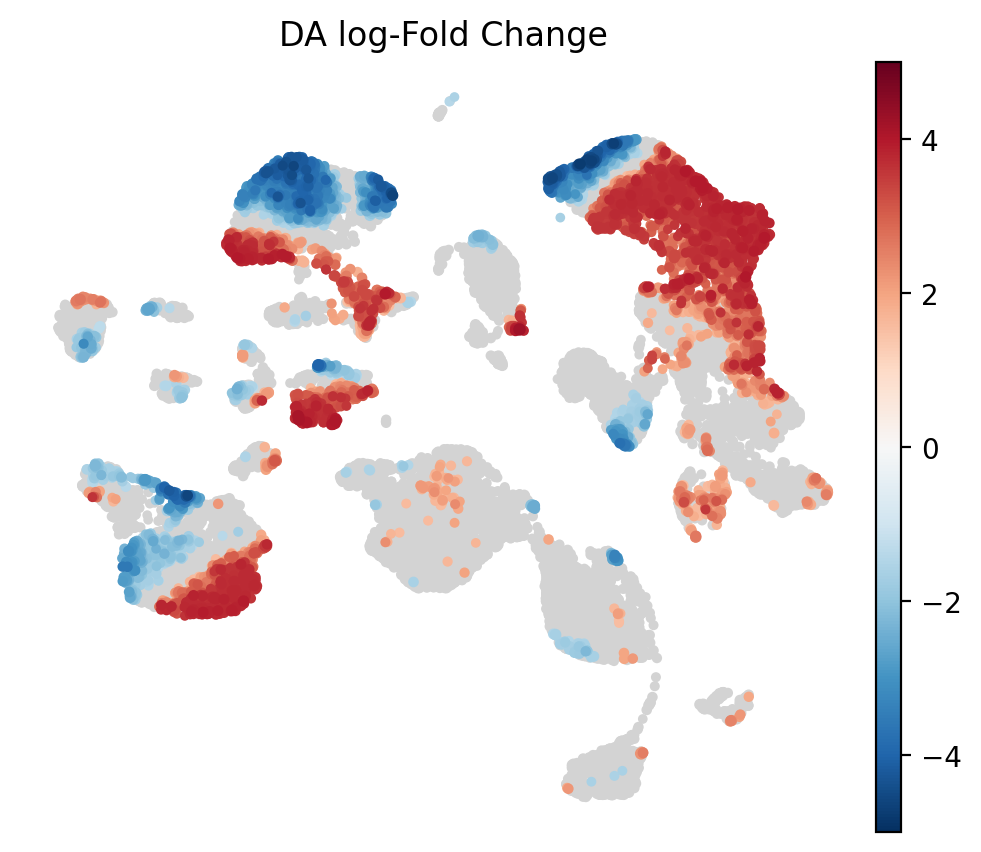

In [48]:
plt.rcParams["figure.figsize"] = [6, 5]
milo.plot_nhood_graph(
    mdata,
    alpha=0.05,  ## SpatialFDR level (1%)
    min_size=1, ## Size of smallest dot
    vmin=-5,
    vmax=5,
    save=("_whole_bleo_vs_control.pdf"))

Text(0.5, 0, 'celltype fraction')

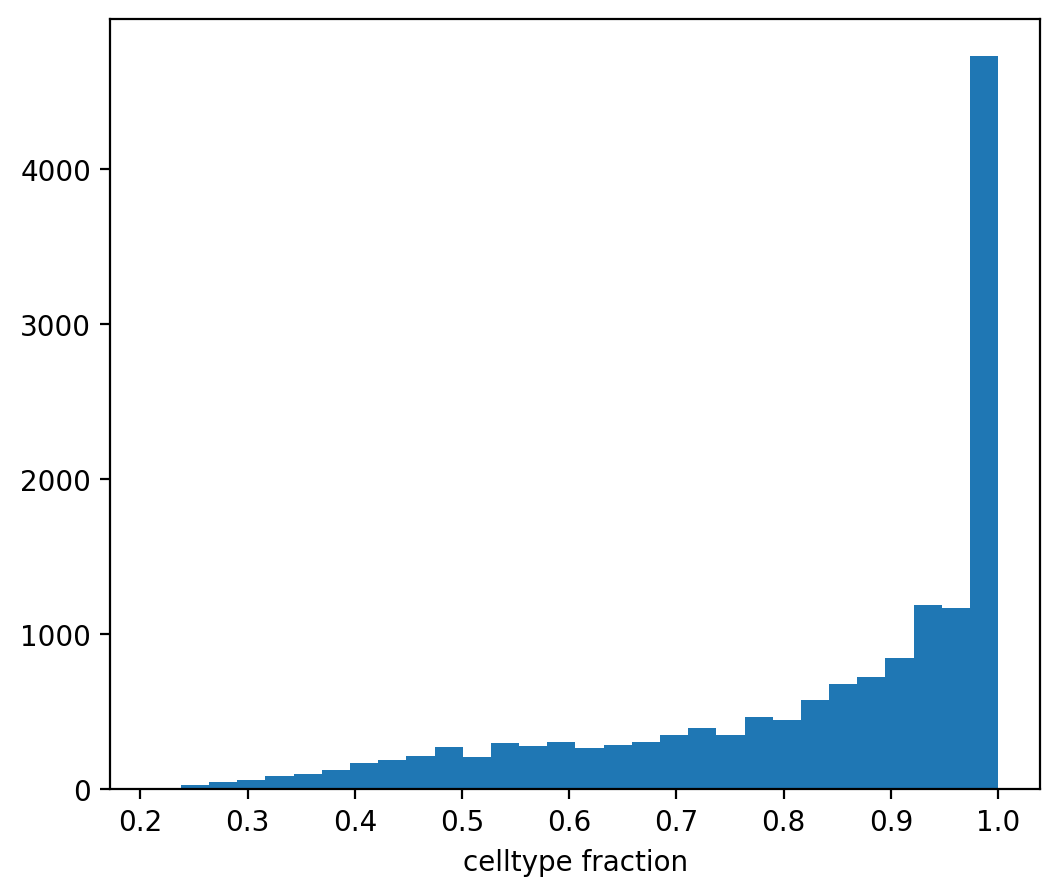

In [49]:
milo.annotate_nhoods(mdata, anno_col="cell_type")
plt.hist(mdata["milo"].var["nhood_annotation_frac"], bins=30)
plt.xlabel("celltype fraction")

In [50]:
mdata["milo"].var.nhood_annotation = mdata["milo"].var.nhood_annotation.cat.add_categories('Mixed')
mdata["milo"].var.loc[mdata["milo"].var["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"
mdata["milo"].var.nhood_annotation = mdata["milo"].var.nhood_annotation.cat.reorder_categories(order)

In [51]:
nhood_adata = mdata["milo"].T.copy()
anno_col = "nhood_annotation"
alpha = 0.05
anno_df = nhood_adata.obs[[anno_col, "logFC", "SpatialFDR"]].copy()
anno_df["is_signif"] = anno_df["SpatialFDR"] < alpha
anno_df = anno_df[anno_df[anno_col] != "nan"]

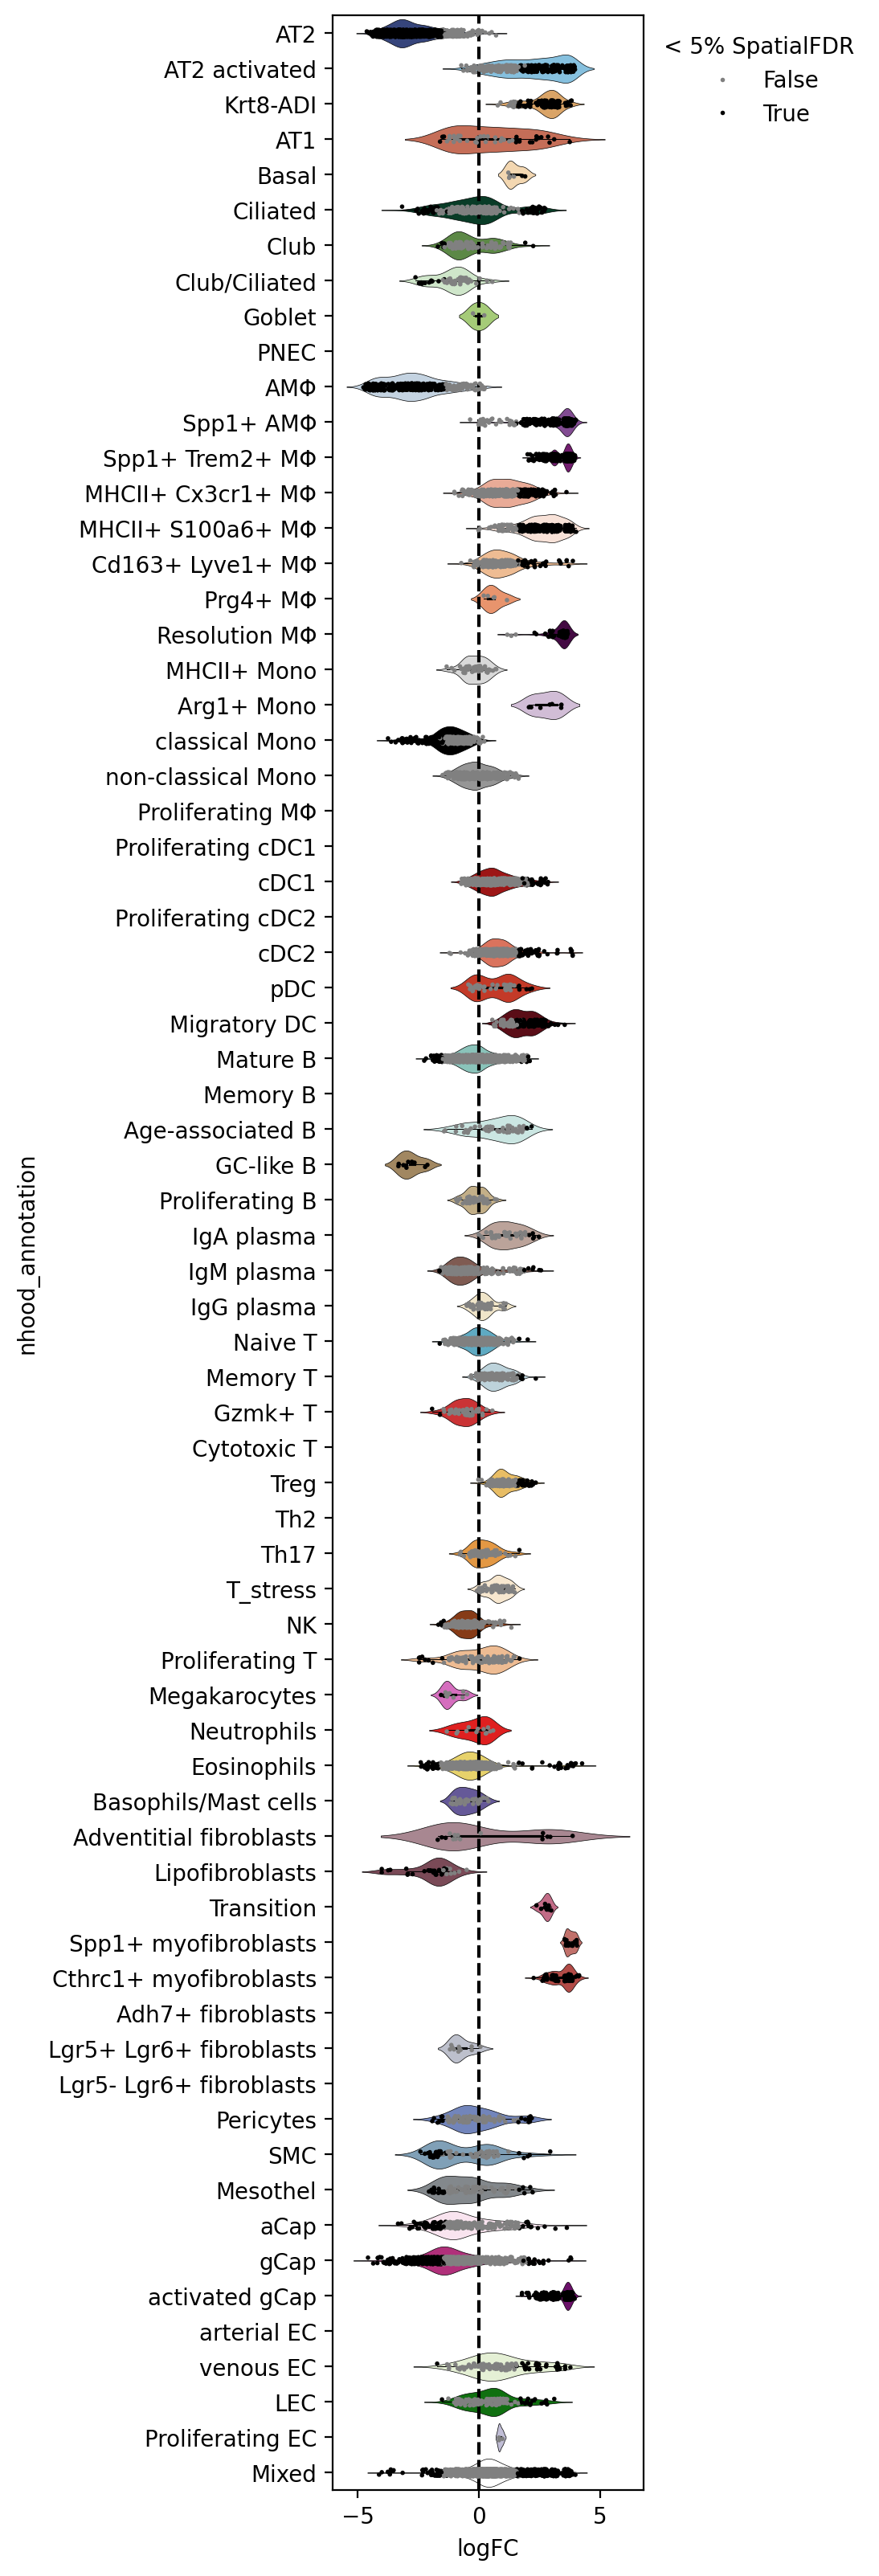

In [52]:
fig, ax = plt.subplots()
fig.set_size_inches(2.5,20)
sns.violinplot(data=anno_df, y=anno_col, x="logFC", order=order, orient="h", palette=new_cols, linewidth=0.25,
               scale="width", edgecolor="black")
sns.stripplot(data=anno_df, y=anno_col, x="logFC", order=order, size=2, hue="is_signif", palette=["grey", "black"], orient="h", alpha=1)
plt.legend(loc="upper left", title=f"< {int(alpha * 100)}% SpatialFDR", bbox_to_anchor=(1, 1), frameon=False)
plt.axvline(x=0, ymin=0, ymax=1, color="black", linestyle="--")
plt.savefig("/home/gotej/Projects/Aging_BleoModel/Paper_figures/figures/" + "_Milo_bs_unsorted_bleo_vs_control.pdf" )

### MiloPy - Young Bleo vs Young Control

In [53]:
mdata["rna"].obs["age_treatment"] = mdata["rna"].obs["age_treatment"].cat.reorder_categories(["young_control", "old_control", "young_bleo", "old_bleo"])
milo.da_nhoods(mdata, design="~age_treatment", model_contrasts="age_treatmentyoung_bleo-age_treatmentyoung_control")

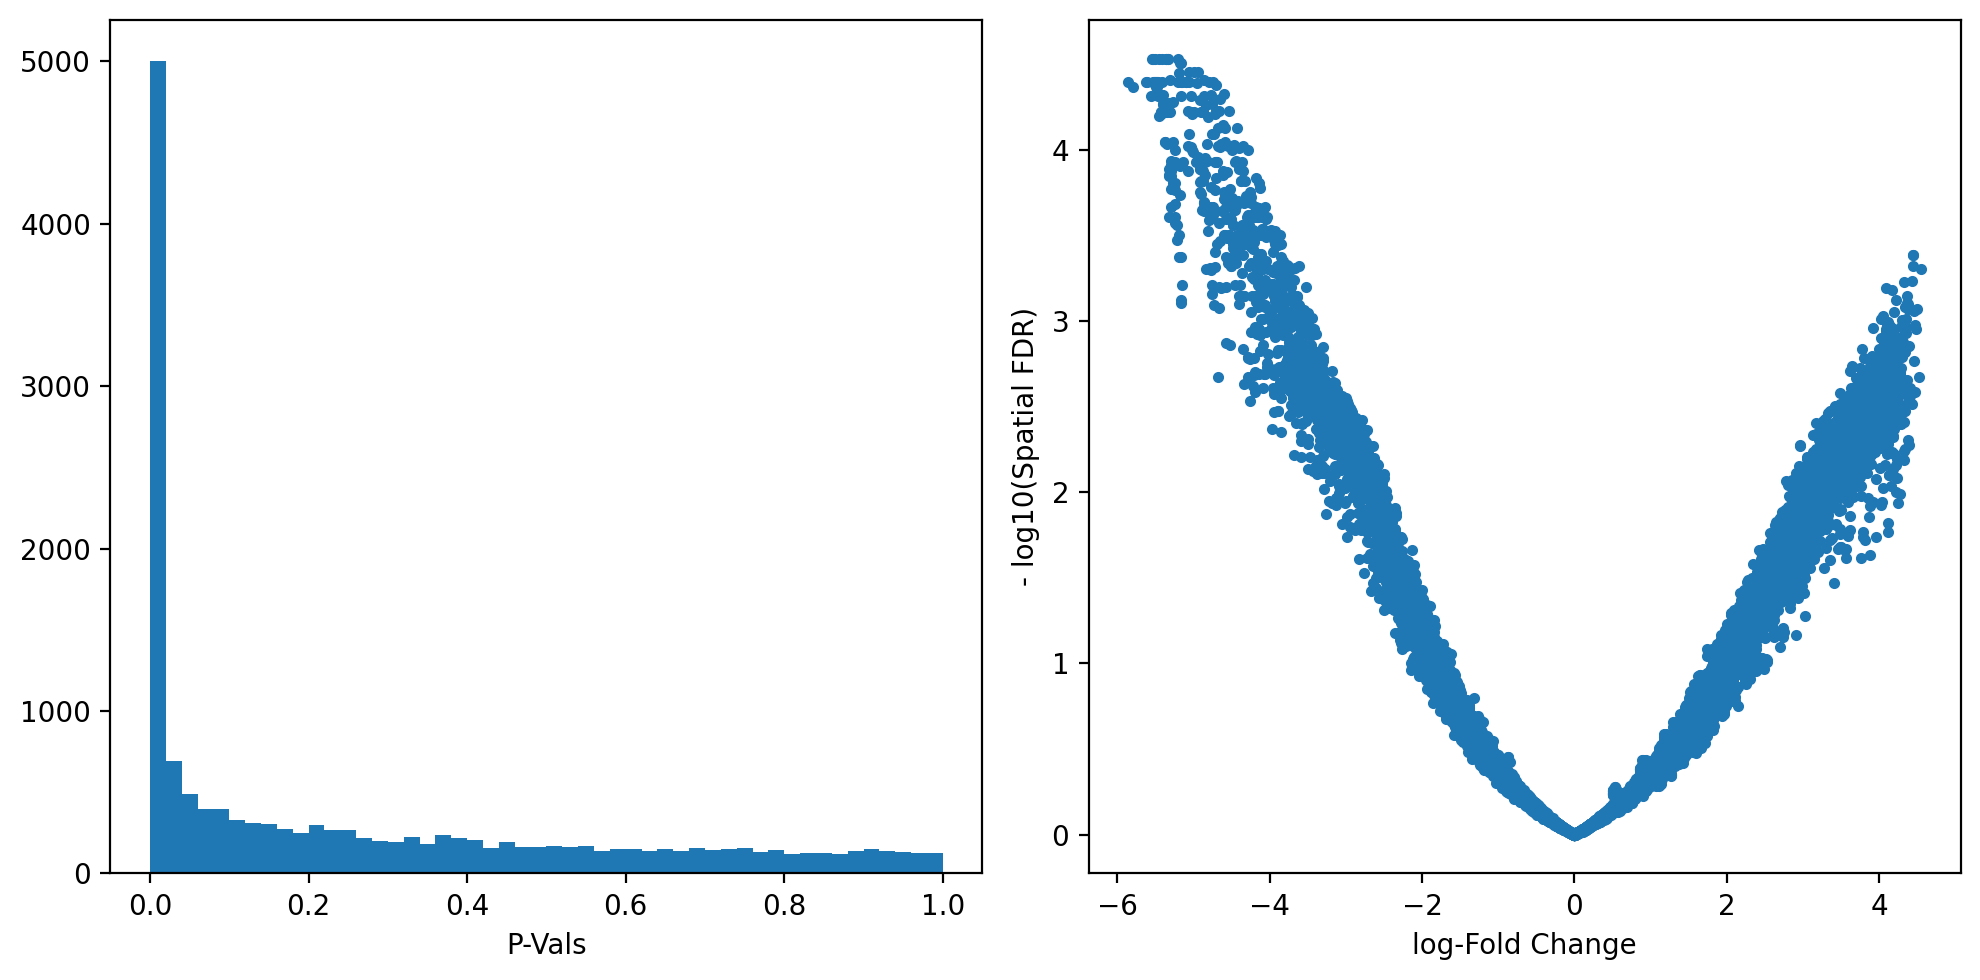

In [54]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10, 5]
plt.subplot(1, 2, 1)
plt.hist(mdata["milo"].var.PValue, bins=50)
plt.xlabel("P-Vals")
plt.subplot(1, 2, 2)
plt.plot(mdata["milo"].var.logFC, -np.log10(mdata["milo"].var.SpatialFDR), ".")
plt.xlabel("log-Fold Change")
plt.ylabel("- log10(Spatial FDR)")
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

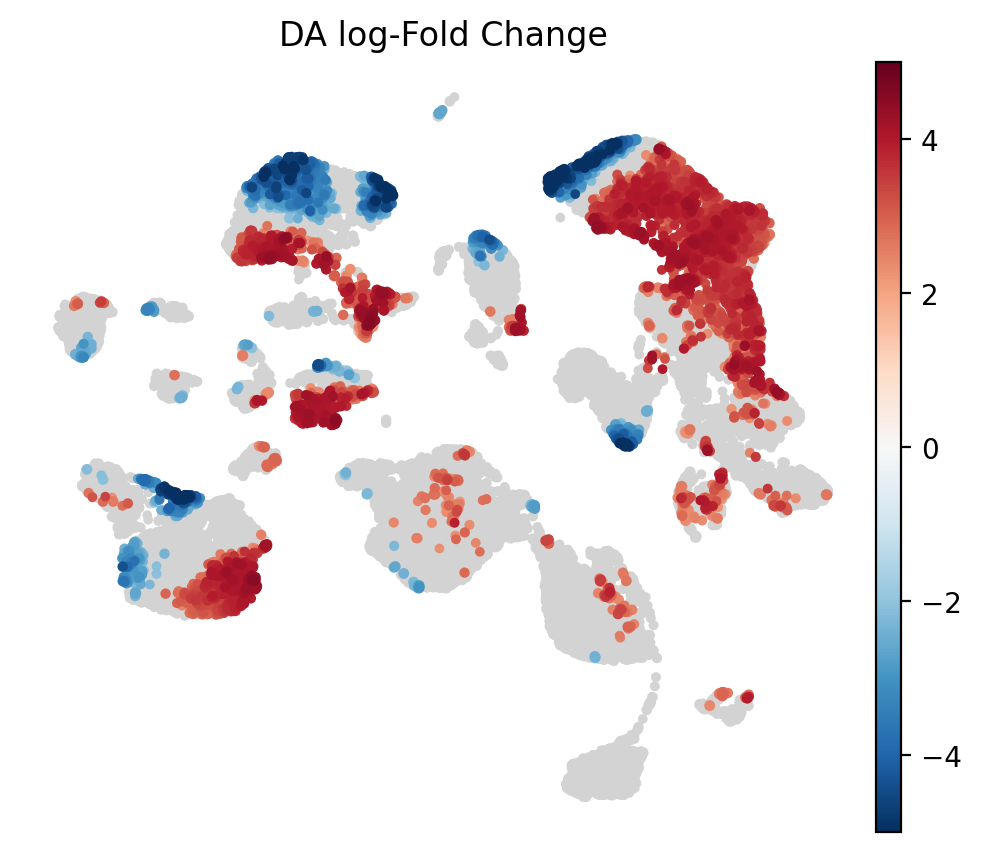

In [55]:
plt.rcParams["figure.figsize"] = [6, 5]
milo.plot_nhood_graph(
    mdata,
    alpha=0.05,  ## SpatialFDR level (1%)
    min_size=1, ## Size of smallest dot
    vmin=-5,
    vmax=5,
    save=("_whole_young_bleo_vs_young_control.pdf"))

Text(0.5, 0, 'celltype fraction')

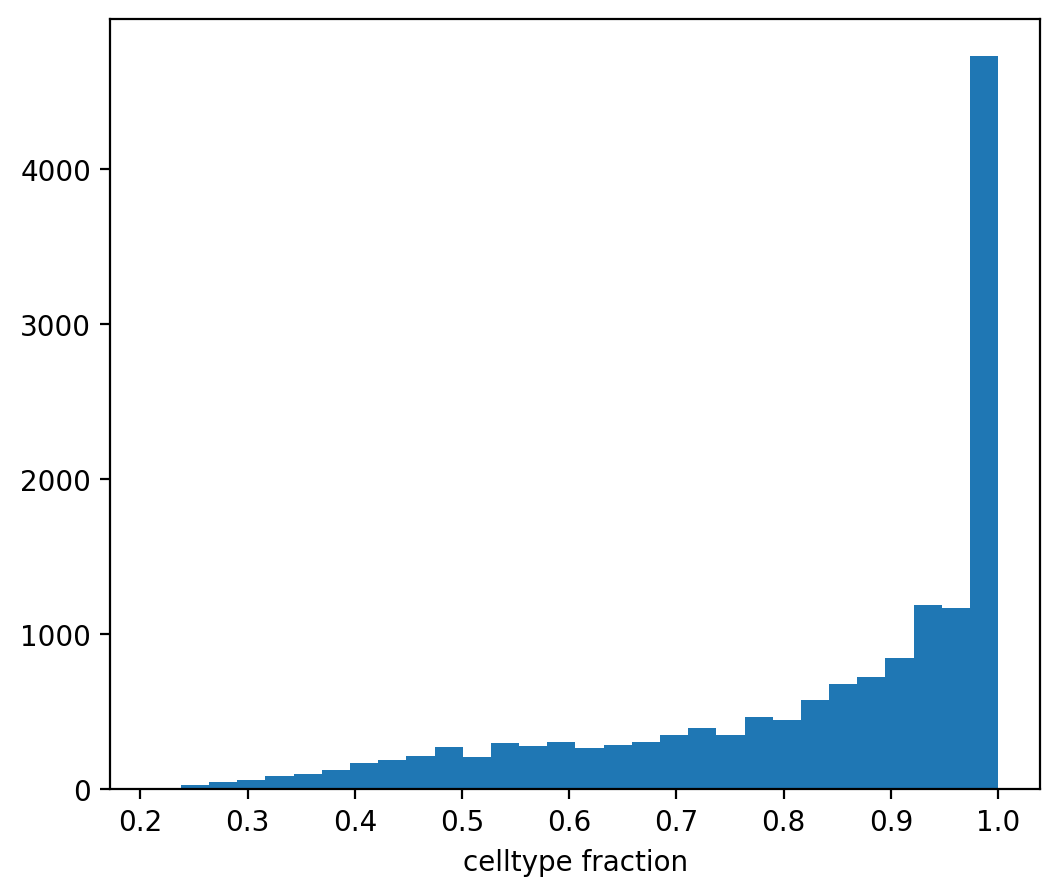

In [56]:
milo.annotate_nhoods(mdata, anno_col="cell_type")
plt.hist(mdata["milo"].var["nhood_annotation_frac"], bins=30)
plt.xlabel("celltype fraction")

In [57]:
mdata["milo"].var.nhood_annotation = mdata["milo"].var.nhood_annotation.cat.add_categories('Mixed')
mdata["milo"].var.loc[mdata["milo"].var["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"
mdata["milo"].var.nhood_annotation = mdata["milo"].var.nhood_annotation.cat.reorder_categories(order)

In [58]:
nhood_adata = mdata["milo"].T.copy()
anno_col = "nhood_annotation"
alpha = 0.05
anno_df = nhood_adata.obs[[anno_col, "logFC", "SpatialFDR"]].copy()
anno_df["is_signif"] = anno_df["SpatialFDR"] < alpha
anno_df = anno_df[anno_df[anno_col] != "nan"]

In [59]:
nhood_adata = mdata["milo"].T.copy()
anno_col = "nhood_annotation"
alpha = 0.05
young_df = nhood_adata.obs[[anno_col, "logFC", "SpatialFDR"]].copy()
young_df["is_signif"] = anno_df["SpatialFDR"] < alpha
young_df = anno_df[anno_df[anno_col] != "nan"]
young_df["age"] = "young"

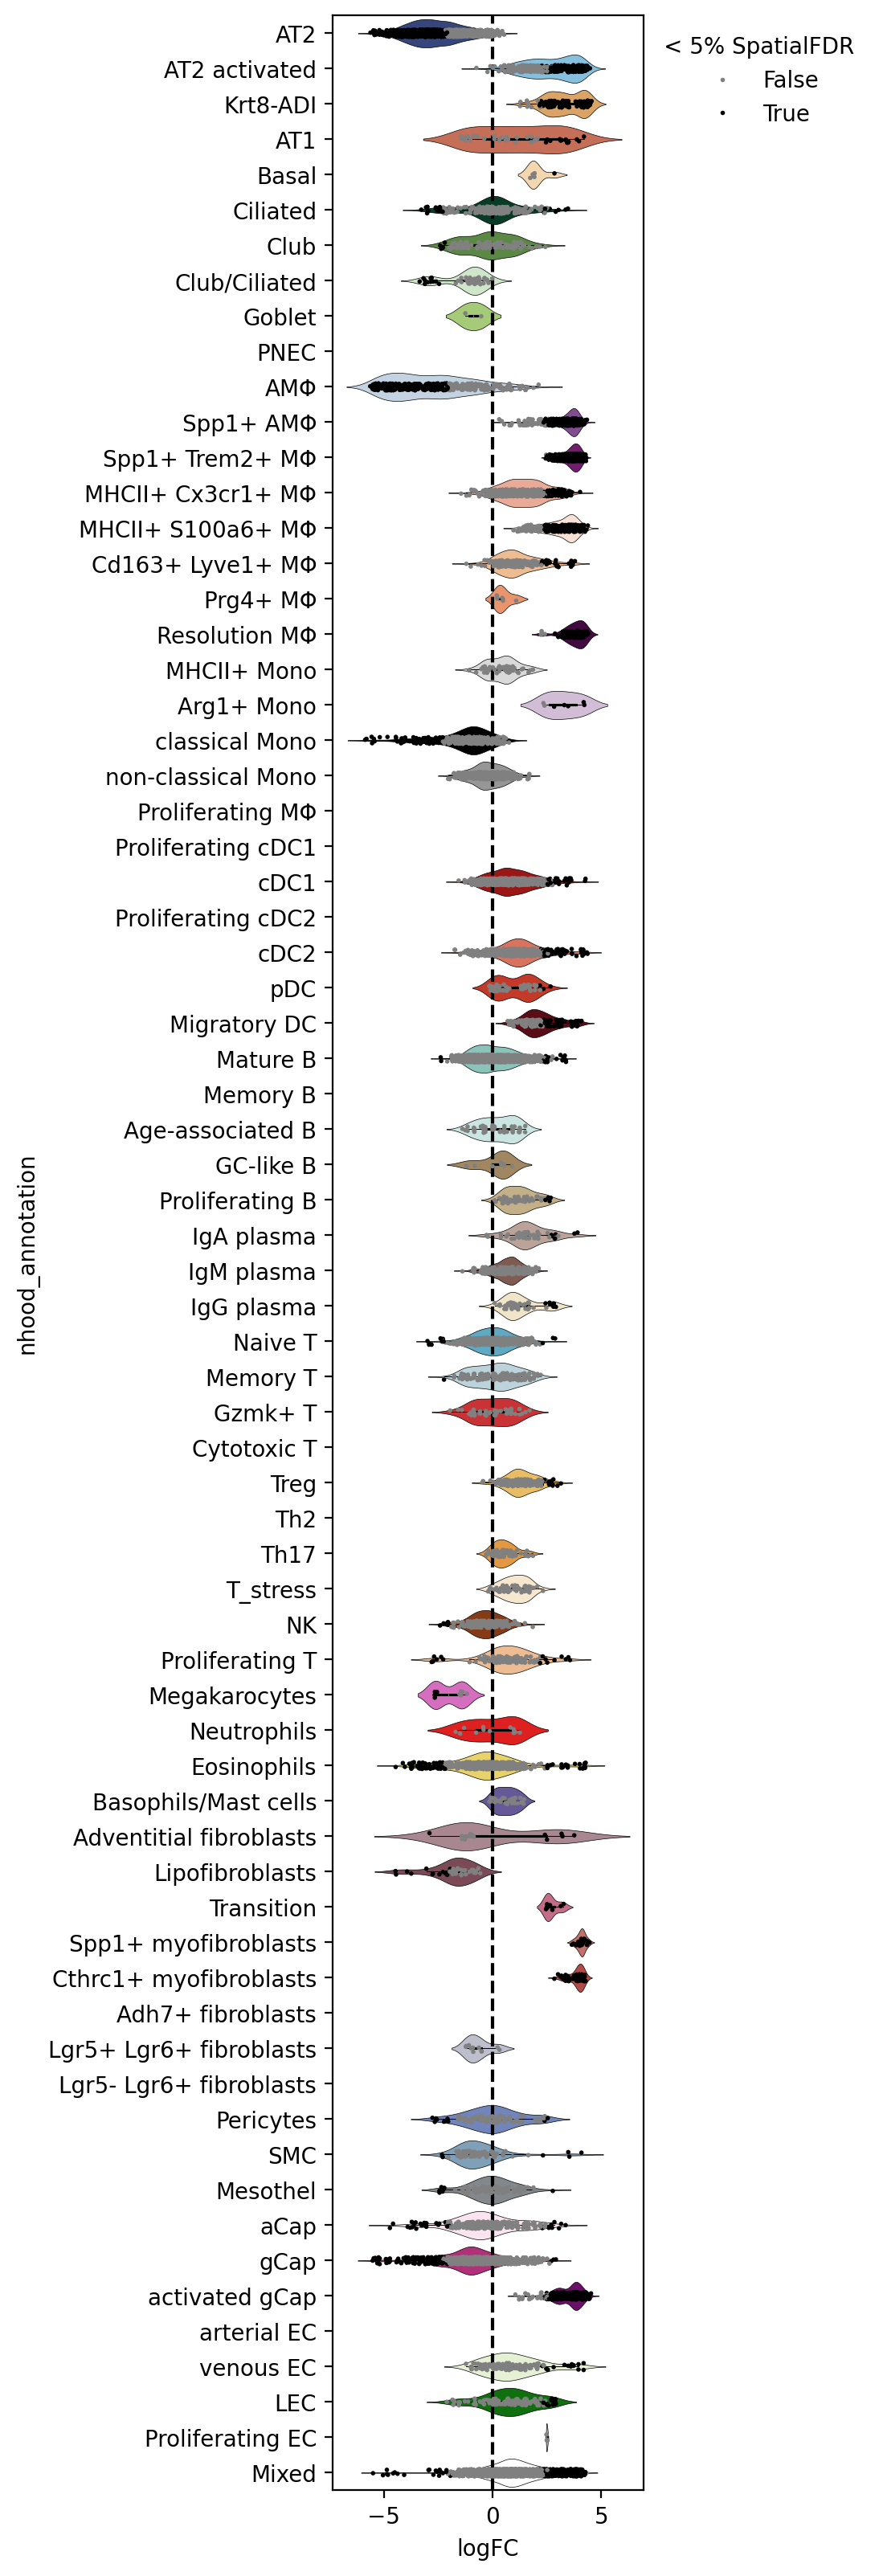

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches(2.5,20)
sns.violinplot(data=anno_df, y=anno_col, x="logFC", order=order, orient="h", palette=new_cols, linewidth=0.25,
               scale="width", edgecolor="black")
sns.stripplot(data=anno_df, y=anno_col, x="logFC", order=order, size=2, hue="is_signif", palette=["grey", "black"], orient="h", alpha=1)
plt.legend(loc="upper left", title=f"< {int(alpha * 100)}% SpatialFDR", bbox_to_anchor=(1, 1), frameon=False)
plt.axvline(x=0, ymin=0, ymax=1, color="black", linestyle="--")
plt.savefig("/home/gotej/Projects/Aging_BleoModel/Paper_figures/figures/" + "_Milo_bs_unsorted_young_bleo_vs_young_control.pdf" )

### Combined young and old bleo vs control injury results

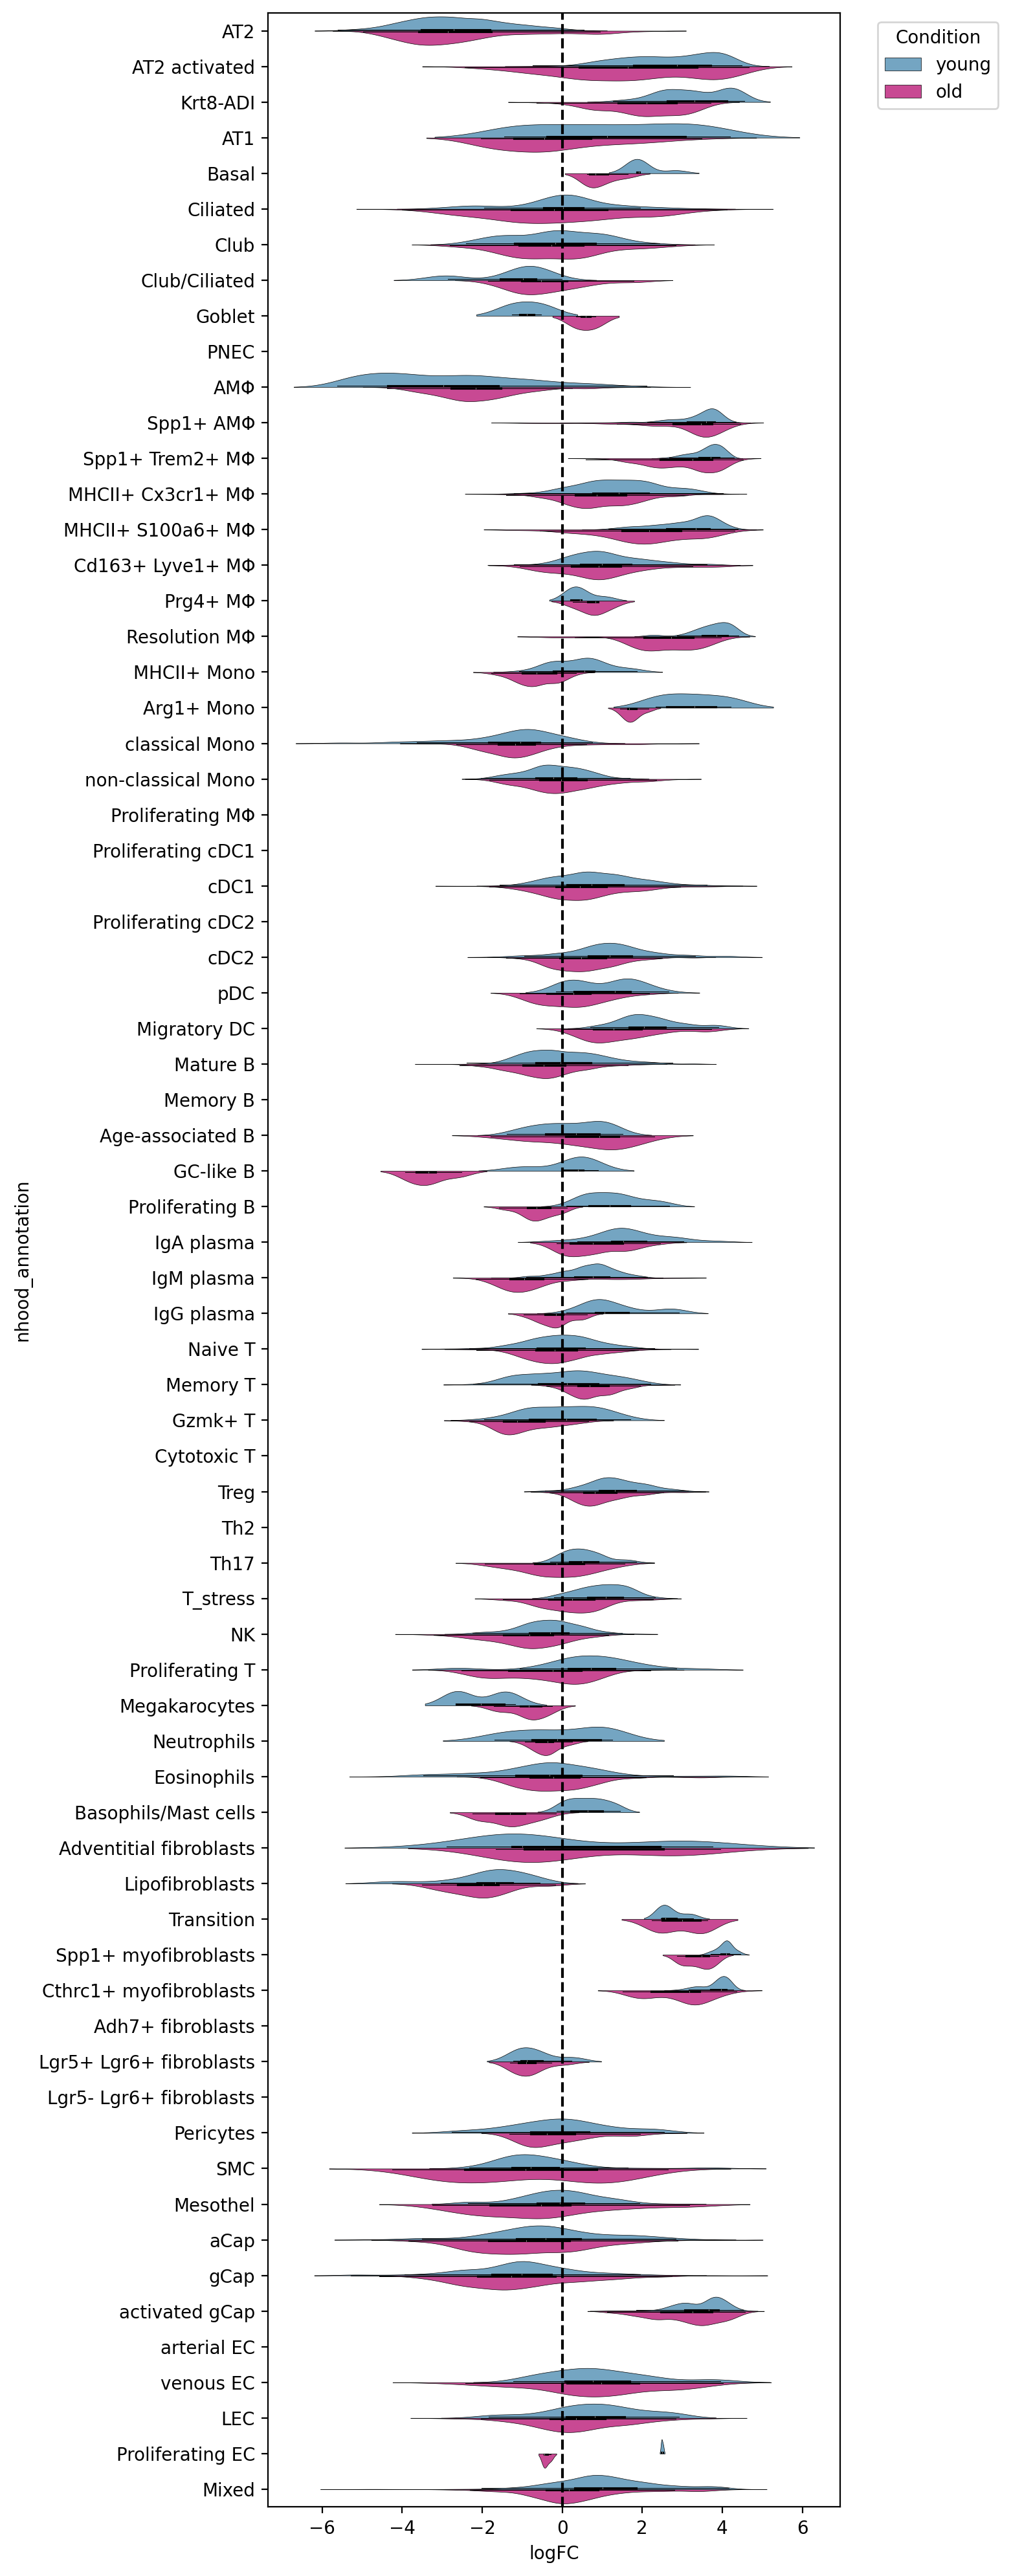

In [61]:
combined_df = pd.concat([young_df, old_df])

cols_age = {
    'young': '#67a9cf',  # light blue
    'old': '#dd3497'     # pink
}

# Plot
fig, ax = plt.subplots(figsize=(8, 20))
sns.violinplot(
    data=combined_df, 
    x="logFC", 
    y=anno_col, 
    hue="age", 
    split=True, 
    scale="width",
    palette= cols_age, 
    orient="h",
    linewidth=0.25,
    edgecolor="black"
)
plt.axvline(x=0, color="black", linestyle="--")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("/home/gotej/Projects/Aging_BleoModel/Paper_figures/figures/milo_all_celltypes_young_vs_old_injury_induced.pdf")
plt.show()
